In [1]:
data_str = """
"Day","Outlook","Temperature","Humidity","Wind","Play"
"D1","Sunny","Hot","High","Weak","No"
"D2","Sunny","Hot","High","Strong","No"
"D3","Overcast","Hot","High","Weak","Yes"
"D4","Rain","Mild","High","Weak","Yes"
"D5","Rain","Cool","Normal","Weak","Yes"
"D6","Rain","Cool","Normal","Strong","No"
"D7","Overcast","Cool","Normal","Strong","Yes"
"D8","Sunny","Mild","High","Weak","No"
"D9","Sunny","Cool","Normal","Weak","Yes"
"D10","Rain","Mild","Normal","Weak","Yes"
"D11","Sunny","Mild","Normal","Strong","Yes"
"D12","Overcast","Mild","High","Strong","Yes"
"D13","Overcast","Hot","Normal","Weak","Yes"
"D14","Rain","Mild","High","Strong","No"
"""

In [2]:
import pandas as pd
import numpy as np
from io import StringIO
np.random.seed(42)

# Decision Tree

- build a decision tree
- train and predict on simple training data set

In [5]:
data_io = StringIO(data_str)
data_set = pd.read_csv(open('data.csv', 'r'))

In [6]:
data_set

,Day,Outlook,Temperature,Humidity,Wind,Play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


## Divide data set into two

In [15]:
def divide(data_set, column, condition):
    part_a = data_set[data_set[column] == condition]
    part_b = data_set[data_set[column] != condition]
    return part_a, part_b

divide(data_set, "Humidity", "High")

(    Day   Outlook Temperature Humidity    Wind Play
 0    D1     Sunny         Hot     High    Weak   No
 1    D2     Sunny         Hot     High  Strong   No
 2    D3  Overcast         Hot     High    Weak  Yes
 3    D4      Rain        Mild     High    Weak  Yes
 7    D8     Sunny        Mild     High    Weak   No
 11  D12  Overcast        Mild     High  Strong  Yes
 13  D14      Rain        Mild     High  Strong   No,
     Day   Outlook Temperature Humidity    Wind Play
 4    D5      Rain        Cool   Normal    Weak  Yes
 5    D6      Rain        Cool   Normal  Strong   No
 6    D7  Overcast        Cool   Normal  Strong  Yes
 8    D9     Sunny        Cool   Normal    Weak  Yes
 9   D10      Rain        Mild   Normal    Weak  Yes
 10  D11     Sunny        Mild   Normal  Strong  Yes
 12  D13  Overcast         Hot   Normal    Weak  Yes)

## Calculate Entropy

In [35]:
import math as math
def entropy(labels):
    counts = labels.value_counts()
    total = sum(counts)
    entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
#     s = 0
#     for c in counts:
#         s += (c/total) * math.log2(c/total)
    return entropy

entropy(data_set.Play)

0.9402859586706311

In [18]:
data_set.Play.value_counts()

Yes    9
No     5
Name: Play, dtype: int64

In [36]:
entropy(data_set[data_set.Humidity == 'High'].Play)

0.9852281360342516

In [37]:
entropy(data_set[data_set.Humidity == 'Normal'].Play)

0.5916727785823275

## Calculate sum of entropy for two set

In [38]:
def entropy_sum(set_a, set_b):
    size_a = set_a.shape[0]
    size_b = set_b.shape[0]
    total = size_a + size_b
    total_entropy = size_a / total * entropy(set_a) + size_b / total * entropy(set_b)
    return total_entropy

set_a, set_b = divide(data_set, "Humidity", "Normal")
entropy_sum(set_a.Play, set_b.Play)

0.7884504573082896

## Calculate information gain

In [39]:
def information_gain(data_set, column, condition):
    set_a, set_b = divide(data_set, column, condition)
    gain = entropy(data_set.iloc[:, -1]) - entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
    return gain

print(information_gain(data_set, "Wind", "Weak"))
print(information_gain(data_set, "Humidity" ,"High"))

0.04812703040826949
0.15183550136234159


In [40]:
data_set = data_set.drop('Day', axis=1)

In [43]:
data_set['Outlook'].unique().tolist()

['Sunny', 'Overcast', 'Rain']

## Pick out the best split value on best split column

In [44]:
columns = data_set.columns.values.tolist()
best_gain = 0
best_split_col = None
best_split_value = None

for column_name in columns[:-1]:
    current_column = data_set[column_name]
    unique_values = current_column.unique().tolist()
    for value in unique_values:
        gain = information_gain(data_set, column_name, value)
        if gain > best_gain:
            best_gain = gain
            best_split_col = column_name
            best_split_value = value

print(best_gain, best_split_col, best_split_value)
set_a, set_b = divide(data_set, best_split_col, best_split_value)
print(set_a, "\n====\n", set_b)

0.22600024438491684 Outlook Overcast
     Outlook Temperature Humidity    Wind Play
2   Overcast         Hot     High    Weak  Yes
6   Overcast        Cool   Normal  Strong  Yes
11  Overcast        Mild     High  Strong  Yes
12  Overcast         Hot   Normal    Weak  Yes 
====
    Outlook Temperature Humidity    Wind Play
0    Sunny         Hot     High    Weak   No
1    Sunny         Hot     High  Strong   No
3     Rain        Mild     High    Weak  Yes
4     Rain        Cool   Normal    Weak  Yes
5     Rain        Cool   Normal  Strong   No
7    Sunny        Mild     High    Weak   No
8    Sunny        Cool   Normal    Weak  Yes
9     Rain        Mild   Normal    Weak  Yes
10   Sunny        Mild   Normal  Strong  Yes
13    Rain        Mild     High  Strong   No


## Integrate into DecisionNode Class

In [46]:
class DecisionNode:
    def __init__(self, depth = 0):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        
    def _divide(self, data_set, column, condition):
        part_a = data_set[data_set[column] == condition]
        part_b = data_set[data_set[column] != condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set):
        columns = data_set.columns.values.tolist()
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in columns[:-1]:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0:
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            self._left_child = DecisionNode(self._depth + 1)
            self._left_child.fit(set_a)
            
            self._right_child = DecisionNode(self._depth + 1)
            self._right_child.fit(set_b)
        else:
            self._leaf_value = data_set.iloc[:,-1].unique()[0]
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str

root = DecisionNode()
root.fit(data_set)
print(root)

>Split Outlook on Overcast
	>LEAF: Yes
	>Split Humidity on High
		>Split Outlook on Sunny
			>LEAF: No
			>Split Wind on Weak
				>LEAF: Yes
				>LEAF: No
		>Split Wind on Weak
			>LEAF: Yes
			>Split Outlook on Rain
				>LEAF: No
				>LEAF: Yes



## Add prediction function

In [47]:
class DecisionNode:
    def __init__(self, depth = 0):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        
    def _divide(self, data_set, column, condition):
        part_a = data_set[data_set[column] == condition]
        part_b = data_set[data_set[column] != condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set):
        columns = data_set.columns.values.tolist()
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in columns[:-1]:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0:
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            self._left_child = DecisionNode(self._depth + 1)
            self._left_child.fit(set_a)
            
            self._right_child = DecisionNode(self._depth + 1)
            self._right_child.fit(set_b)
        else:
            self._leaf_value = data_set.iloc[:,-1].unique()[0]
            
    def predict_single(self, record):
        if self._left_child is None and self._right_child is None:
            return self._leaf_value
        else:
            go_left = record[self._best_split_col] == self._best_split_value
            if go_left:
                return self._left_child.predict_single(record)
            else:
                return self._right_child.predict_single(record)
    
    def predict(self, data_set):
        return data_set.apply(self.predict_single, axis=1)
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str




root = DecisionNode()
root.fit(data_set)
print(root)
print(data_set)
print(root.predict(data_set))

>Split Outlook on Overcast
	>LEAF: Yes
	>Split Humidity on High
		>Split Outlook on Sunny
			>LEAF: No
			>Split Wind on Weak
				>LEAF: Yes
				>LEAF: No
		>Split Wind on Weak
			>LEAF: Yes
			>Split Outlook on Rain
				>LEAF: No
				>LEAF: Yes

     Outlook Temperature Humidity    Wind Play
0      Sunny         Hot     High    Weak   No
1      Sunny         Hot     High  Strong   No
2   Overcast         Hot     High    Weak  Yes
3       Rain        Mild     High    Weak  Yes
4       Rain        Cool   Normal    Weak  Yes
5       Rain        Cool   Normal  Strong   No
6   Overcast        Cool   Normal  Strong  Yes
7      Sunny        Mild     High    Weak   No
8      Sunny        Cool   Normal    Weak  Yes
9       Rain        Mild   Normal    Weak  Yes
10     Sunny        Mild   Normal  Strong  Yes
11  Overcast        Mild     High  Strong  Yes
12  Overcast         Hot   Normal    Weak  Yes
13      Rain        Mild     High  Strong   No
0      No
1      No
2     Yes
3     Yes
4     Ye

# Enhanced decision tree
- Add the capability to deal with numbers

In [49]:
iris = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'iris_type'])

In [50]:
iris = iris[['sepal_length', 'sepal_width', 'iris_type']]

In [53]:
test_set = iris.sample(frac=0.1, random_state=42)

In [54]:
iris_decision_tree = DecisionNode()
iris_decision_tree.fit(test_set)
print(iris_decision_tree)

>Split sepal_width on 2.8
	>LEAF: Iris-versicolor
	>Split sepal_width on 2.9
		>LEAF: Iris-versicolor
		>Split sepal_length on 6.2
			>LEAF: Iris-versicolor
			>Split sepal_length on 5.8
				>LEAF: Iris-versicolor
				>Split sepal_length on 7.7
					>LEAF: Iris-virginica
					>Split sepal_length on 6.9
						>LEAF: Iris-virginica
						>Split sepal_length on 6.5
							>LEAF: Iris-virginica
							>LEAF: Iris-setosa



In [56]:
class DecisionNode:
    def __init__(self, depth = 0):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        
    def _divide(self, data_set, column, condition):
        if isinstance(condition, str):
            part_a = data_set[data_set[column] == condition]
            part_b = data_set[data_set[column] != condition]
        else:
            part_a = data_set[data_set[column] >= condition]
            part_b = data_set[data_set[column] < condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set):
        columns = data_set.columns.values.tolist()
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in columns[:-1]:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0:
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            self._left_child = DecisionNode(self._depth + 1)
            self._left_child.fit(set_a)
            
            self._right_child = DecisionNode(self._depth + 1)
            self._right_child.fit(set_b)
        else:
            self._leaf_value = data_set.iloc[:,-1].unique()[0]
            
    def predict_single(self, record):
        if self._left_child is None and self._right_child is None:
            return self._leaf_value
        else:
            if isinstance(self._best_split_value, str):
                go_left = record[self._best_split_col] == self._best_split_value
            else:
                go_left = record[self._best_split_col] >= self._best_split_value
                
            if go_left:
                return self._left_child.predict_single(record)
            else:
                return self._right_child.predict_single(record)
    
    def predict(self, data_set):
        return data_set.apply(self.predict_single, axis=1)
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str

root = DecisionNode()
root.fit(test_set)
print(root)
print(test_set)
print(root.predict(test_set))

>Split sepal_width on 3.0
	>Split sepal_length on 6.5
		>LEAF: Iris-virginica
		>LEAF: Iris-setosa
	>Split sepal_length on 7.7
		>LEAF: Iris-virginica
		>LEAF: Iris-versicolor

     sepal_length  sepal_width        iris_type
73            6.1          2.8  Iris-versicolor
18            5.7          3.8      Iris-setosa
118           7.7          2.6   Iris-virginica
78            6.0          2.9  Iris-versicolor
76            6.8          2.8  Iris-versicolor
31            5.4          3.4      Iris-setosa
64            5.6          2.9  Iris-versicolor
141           6.9          3.1   Iris-virginica
68            6.2          2.2  Iris-versicolor
82            5.8          2.7  Iris-versicolor
110           6.5          3.2   Iris-virginica
12            4.8          3.0      Iris-setosa
36            5.5          3.5      Iris-setosa
9             4.9          3.1      Iris-setosa
19            5.1          3.8      Iris-setosa
73     Iris-versicolor
18         Iris-setosa
118     I

In [57]:
root = DecisionNode()
root.fit(iris)

## Visualization

<IPython.core.display.Javascript object>


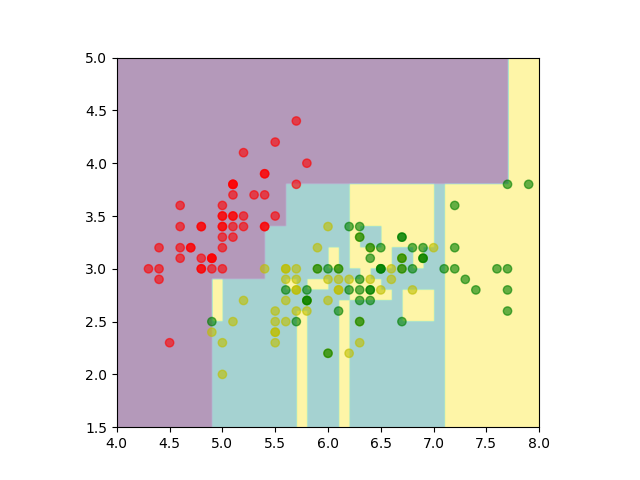

In [58]:
%matplotlib notebook
import matplotlib.pyplot as plt

def visualize(root):
    grid = np.mgrid[4:8:400j,1.5:5:350j]
    gridT = grid.reshape((2,-1)).T
    labels = root.predict(pd.DataFrame(gridT, columns=['sepal_length','sepal_width']))
    labels[labels == 'Iris-setosa'] = 1.0
    labels[labels == 'Iris-versicolor'] = 2.0
    labels[labels == 'Iris-virginica'] = 3.0
    labels = labels.astype('float')
    col = {'Iris-setosa':'r', 'Iris-versicolor':'y', 'Iris-virginica':'g'}
    plt.figure()
    plt.imshow(labels.values.reshape((400,350)).T, interpolation='bicubic', origin='lower', alpha=0.4, extent=[4,8,1.5,5])
    plt.scatter(iris['sepal_length'] ,iris['sepal_width'], c=[col[t] for t in iris['iris_type']], alpha=0.6)
    
visualize(root)

## Add max_depth parameter

<IPython.core.display.Javascript object>


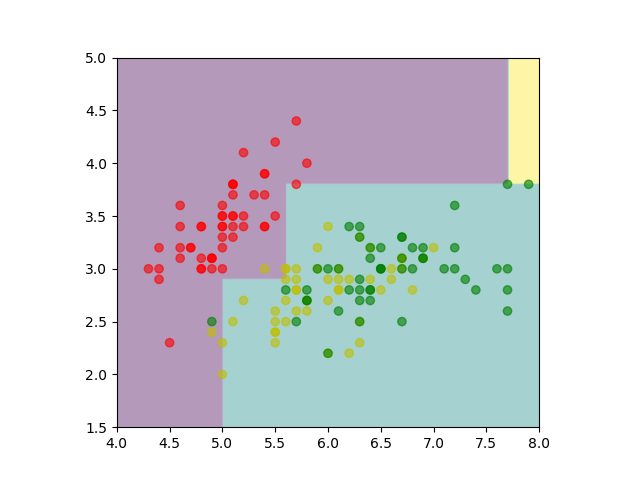

<IPython.core.display.Javascript object>


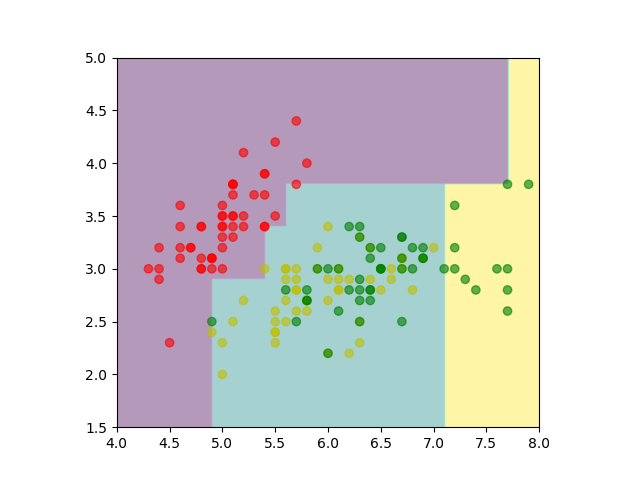

<IPython.core.display.Javascript object>


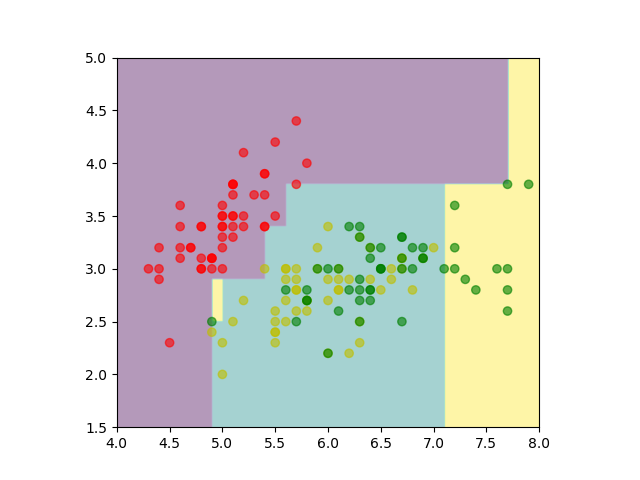

<IPython.core.display.Javascript object>


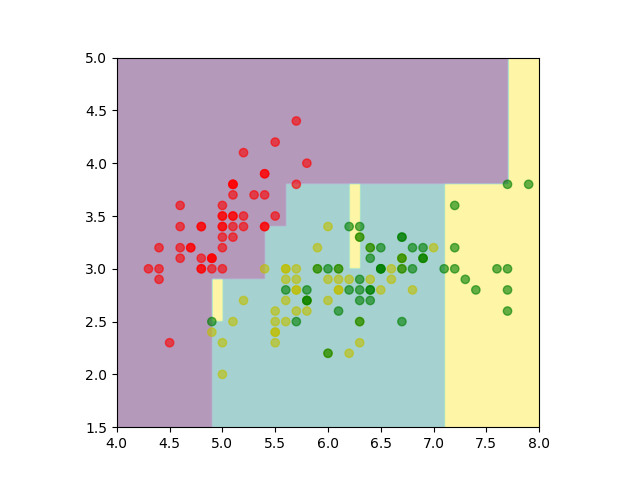

<IPython.core.display.Javascript object>


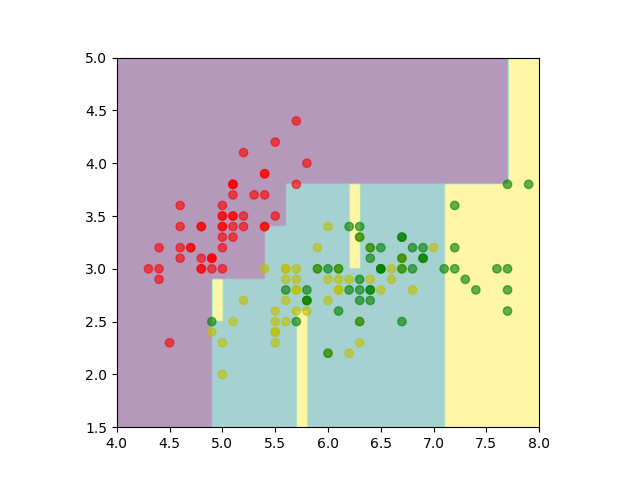

<IPython.core.display.Javascript object>


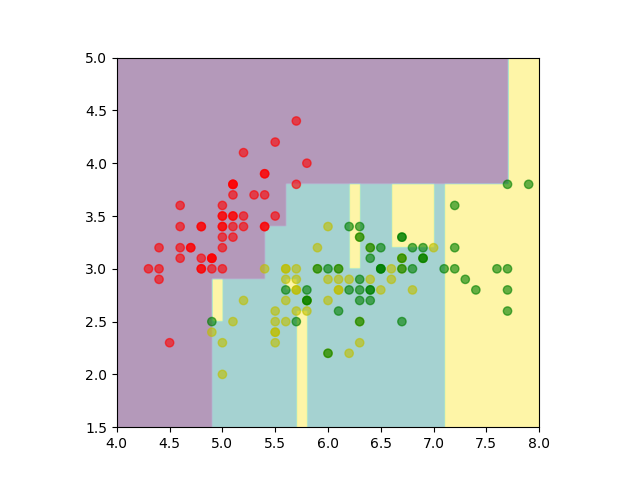

<IPython.core.display.Javascript object>


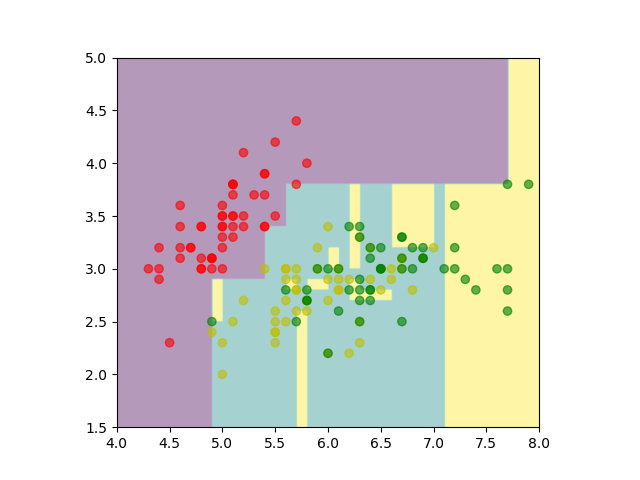

In [60]:
class DecisionNode:
    def __init__(self, depth = 0, max_depth = -1):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        self._max_depth = max_depth
        
    def _divide(self, data_set, column, condition):
        if isinstance(condition, str):
            part_a = data_set[data_set[column] == condition]
            part_b = data_set[data_set[column] != condition]
        else:
            part_a = data_set[data_set[column] >= condition]
            part_b = data_set[data_set[column] < condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set):
        columns = data_set.columns.values.tolist()
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in columns[:-1]:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0 and (self._max_depth == -1 or self._depth < self._max_depth):
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            self._left_child = DecisionNode(self._depth + 1, self._max_depth)
            self._left_child.fit(set_a)
            
            self._right_child = DecisionNode(self._depth + 1, self._max_depth)
            self._right_child.fit(set_b)
        else:
            self._leaf_value = data_set.iloc[:,-1].unique()[0]
            
    def predict_single(self, record):
        if self._left_child is None and self._right_child is None:
            return self._leaf_value
        else:
            if isinstance(self._best_split_value, str):
                go_left = record[self._best_split_col] == self._best_split_value
            else:
                go_left = record[self._best_split_col] >= self._best_split_value
                
            if go_left:
                return self._left_child.predict_single(record)
            else:
                return self._right_child.predict_single(record)
    
    def predict(self, data_set):
        return data_set.apply(self.predict_single, axis=1)
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str
    
for i in range(3,10):
    root = DecisionNode(max_depth=i)
    root.fit(iris)
    visualize(root)

In [61]:
from sklearn.metrics import classification_report
root.fit(iris)
print(classification_report(root.predict(iris), iris.iris_type))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      0.67      0.80        75
 Iris-virginica       0.50      1.00      0.67        25

    avg / total       0.92      0.83      0.84       150



## Test F1 score change with respect to max_depth

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

iris = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'iris_type'])
iris = iris[['sepal_length', 'sepal_width', 'iris_type']]
train, test = train_test_split(iris, test_size=0.5, random_state=42)
for i in range(3,10):
    root = DecisionNode(max_depth=i)
    root.fit(train)
    print(f1_score(root.predict(train), train.iris_type, average='weighted'), f1_score(root.predict(test), test.iris_type, average='weighted'))

0.810666666667 0.723315594259
0.853383647799 0.755476190476
0.807197994987 0.707476190476
0.76032967033 0.687532879819
0.801729505361 0.675982905983
0.880371517028 0.688544285931
0.92044137931 0.71471957672


# Random Forest
- Build a random forest
- Train a random forest on iris dataset

## Implement Random Forest Class

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel\__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sean\Anaconda3\lib\site-packages\scipy\stats\stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


<IPython.core.display.Javascript object>


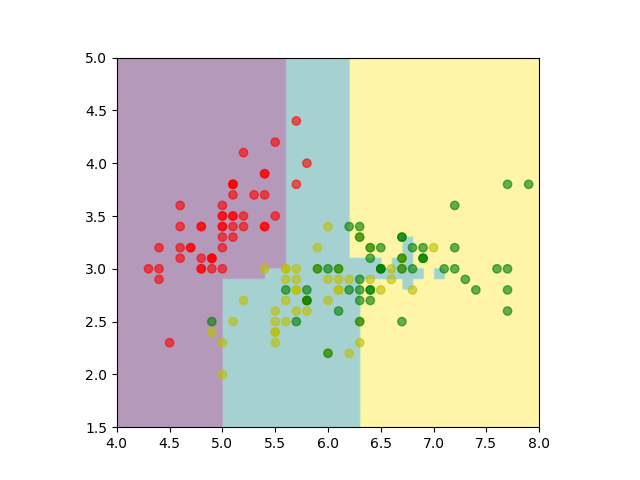

In [67]:
import scipy.stats as stats

class DecisionNode:
    def __init__(self, depth = 0, max_depth = -1):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        self._max_depth = max_depth
        
        
    def _divide(self, data_set, column, condition):
        if isinstance(condition, str):
            part_a = data_set[data_set[column] == condition]
            part_b = data_set[data_set[column] != condition]
        else:
            part_a = data_set[data_set[column] >= condition]
            part_b = data_set[data_set[column] < condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set, selected_features = None):
        if selected_features is None:
            columns = data_set.columns.values.tolist()
            selected_features = columns[:-1]
        
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in selected_features:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0 and (self._max_depth == -1 or self._depth < self._max_depth):
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            self._left_child = DecisionNode(self._depth + 1, self._max_depth)
            self._left_child.fit(set_a)
            
            self._right_child = DecisionNode(self._depth + 1, self._max_depth)
            self._right_child.fit(set_b)
        else:
            self._leaf_value = data_set.iloc[:,-1].unique()[0]
            
    def predict_single(self, record):
        if self._left_child is None and self._right_child is None:
            return self._leaf_value
        else:
            if isinstance(self._best_split_value, str):
                go_left = record[self._best_split_col] == self._best_split_value
            else:
                go_left = record[self._best_split_col] >= self._best_split_value
                
            if go_left:
                return self._left_child.predict_single(record)
            else:
                return self._right_child.predict_single(record)
    
    def predict(self, data_set):
        return data_set.apply(self.predict_single, axis=1)
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str
    
class RandomForest:
    def __init__(self, n_estimator):
        self._n_estimator = n_estimator
        self._trees = []
        
    def fit(self, data_set):
        for i in range(self._n_estimator):
            selected_rows = np.random.choice(data_set.shape[0] - 1, data_set.shape[0] / 3)
            selected_features = np.random.choice(data_set.columns.tolist()[:-1], np.ceil(np.sqrt(data_set.shape[1])), replace=False)
            decision_tree = DecisionNode()
            decision_tree.fit(data_set.iloc[selected_rows,:], selected_features)
            self._trees.append(decision_tree)
            
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            return X.apply(self.predict_single, axis=1)
        else:
            return self.predict_single(X)
        
    def predict_single(self, data_record):
        voting = []
        for tree in self._trees:
            voting.append(tree.predict_single(data_record))
        return stats.mode(voting)[0][0]
    
    
forest = RandomForest(5)
forest.fit(iris)
visualize(forest)

In [69]:
import pickle

In [78]:
forest_str = pickle.dumps (forest)

In [80]:
f = pickle.loads(forest_str)

In [82]:
pickle.dump

b'\x80\x03c__main__\nRandomForest\nq\x00)\x81q\x01}q\x02(X\x0c\x00\x00\x00_n_estimatorq\x03K\x05X\x06\x00\x00\x00_treesq\x04]q\x05(c__main__\nDecisionNode\nq\x06)\x81q\x07}q\x08(X\x0b\x00\x00\x00_left_childq\th\x06)\x81q\n}q\x0b(h\th\x06)\x81q\x0c}q\r(h\th\x06)\x81q\x0e}q\x0f(h\tNX\x0c\x00\x00\x00_right_childq\x10NX\x06\x00\x00\x00_depthq\x11K\x03X\n\x00\x00\x00_max_depthq\x12J\xff\xff\xff\xffX\x0f\x00\x00\x00_best_split_colq\x13NX\x11\x00\x00\x00_best_split_valueq\x14NX\x0b\x00\x00\x00_leaf_valueq\x15X\x0e\x00\x00\x00Iris-virginicaq\x16ubh\x10h\x06)\x81q\x17}q\x18(h\th\x06)\x81q\x19}q\x1a(h\th\x06)\x81q\x1b}q\x1c(h\tNh\x10Nh\x11K\x05h\x12J\xff\xff\xff\xffh\x13Nh\x14Nh\x15h\x16ubh\x10h\x06)\x81q\x1d}q\x1e(h\th\x06)\x81q\x1f}q (h\tNh\x10Nh\x11K\x06h\x12J\xff\xff\xff\xffh\x13Nh\x14Nh\x15X\x0f\x00\x00\x00Iris-versicolorq!ubh\x10h\x06)\x81q"}q#(h\th\x06)\x81q$}q%(h\th\x06)\x81q&}q\'(h\th\x06)\x81q(}q)(h\th\x06)\x81q*}q+(h\tNh\x10Nh\x11K\nh\x12J\xff\xff\xff\xffh\x13Nh\x14Nh\x15h\x16ubh\x10h

## Serialization